# Fake News Detection

## Project description

The goal is to develop a Machine Learning model that can detect fake news with accuracy. The model will be integrated into the Chrome plug-in and will provide users with a real-time indication of the veracity of the news they are reading.

Two [dataset](https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip) are given:
1. Real news 
2. Fake news

Questions to analyze:
1. Are fake news more frequent in a particular category?
2. Are there topics that are more prone to fake news?
3. Do fake news headlines exhibit recurring patterns?

ML Model

- The model will be developed using Natural Language Processing (NLP) and Machine Learning techniques.
- It will be trained with true and fake news datasets to recognize text patterns associated with untrue news. Relevant features, such as headlines, keywords and categories of news will be analyzed.
- Performance metrics (e.g., accuracy, precision, recall) will be used to evaluate the effectiveness of the model.
- Optimization techniques will be applied to improve the ability of fake news recognition.
- Once training is complete, the model will be exported to pickle format for implementation.
- The Machine Learning Engineer and Web Developer team will integrate the model into the Chrome plug-in.

# Import

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from tqdm import tqdm
import time
import joblib
import random

# nlp import
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from bertopic import BERTopic

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import spacy
import spacy.displacy as displacy
import re

from pprint import pprint

# models 
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report, make_scorer


In [64]:
#download
nltk.download('stopwords')
nltk.download('wordnet')
!python -m spacy download en_core_web_sm
nltk.download("vader_lexicon", download_dir="data")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 8.5 MB/s eta 0:00:02
     ----- ---------------------------------- 1.8/12.8 MB 6.3 MB/s eta 0:00:02
     ---------- ----------------------------- 3.4/12.8 MB 6.7 MB/s eta 0:00:02
     ----------------- ---------------------- 5.5/12.8 MB 7.6 MB/s eta 0:00:01
     ---------------------- ----------------- 7.1/12.8 MB 7.7 MB/s eta 0:00:01
     --------------------------- ------------ 8.9/12.8 MB 7.8 MB/s eta 0:00:01
     -------------------------------- ------- 10.5/12.8 MB 7.9 MB/s eta 0:00:01
     -------------------------------------- - 12.3/12.8 MB 7.8 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 7.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package vader_lexicon to data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [65]:
# system variables
stop_words = stopwords.words('english')
random_seed = 0

# Functions

In [66]:
def get_n_colors(n):
    # review da cancellare se non usata
    '''
    Return a list of n colors
    '''
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i) for i in range(n)]
    return colors

In [67]:
def plot_group_by_topic(df, topic, count_col, palette=None, barh=True, percentage=False, r=False):
    #review da cancellare se non usata
    '''
    Show an horizontal bar plot grouping by topic
    y axis shows the subdivision of every topic for subject, label
    Return the df created for the plot
    Assumed a pd.DataFrame structure 
    
    variables: 
        topic, count_col -> str
        palette -> dict (according with topic)
        barh -> True (default) if horizontal bar plot
        r -> True if want the plot df in return
    '''
    
    if not palette:
        # if palette not given is set here
        topics = df[topic].unique()
        colors = get_n_colors(len(topics))
        palette = dict(zip(topics, colors))
    
    
    count_df = df.groupby(by=[topic, count_col]).size().to_frame(name='count')
    count_df['color'] = count_df.index.get_level_values(topic).map(palette)
    count_df['percent'] = count_df.groupby(level=0)['count'].transform(lambda x: 100 * x / x.sum())

    plot_col = str(topic+'_'+count_col)
    count_df[plot_col] = (
        count_df.index.get_level_values(topic).astype(str)
        + '_' +
        count_df.index.get_level_values(count_col).astype(str)
    )
    
    plt.figure(figsize=(10, 6))
    if barh:
        bars = plt.barh(count_df[plot_col], count_df['count'], color=count_df['color'])
        if percentage:
            for i, (bar, pct) in enumerate(zip(bars, count_df['percent'])):
                plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2, f'{pct:.1f}%', va='center')
    else:
        bars = plt.bar(count_df[plot_col], count_df['count'], color=count_df['color'])
        plt.xticks(rotation=90)
        if percentage:
            for i, (bar, pct) in enumerate(zip(bars, count_df['percent'])):
                plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{pct:.1f}%', ha='center')

    plt.ylabel("Frequency")
    plt.title(str("Distribution of "+plot_col))
    plt.tight_layout()
    plt.show()
    
    if r:
        return count_df
    else:
        return None

In [68]:
def fake_real_distribution_entity(df, target, search_col):

    df_word = df.copy()
    df_word['target_count'] = df_word[search_col].str.count(target)

    grouped = df_word.groupby(['target_count', 'label']).size().unstack(fill_value=0)
    res_1 = grouped.reset_index().rename_axis(None, axis=1)
    res_1['fake_pct'] = res_1['fake'] / (res_1['fake'] + res_1['real']) * 100

    res_2 = df_word.groupby('label')['target_count'].sum().reset_index()

    return (res_1, res_2)

In [69]:
from matplotlib.ticker import MaxNLocator
#review
def plot_distribution_entity(df, target, search_col, division=True):
    df_12, df3 = fake_real_distribution_entity(df, target, search_col)

    # divide the plot in 2 chart -> scale motivation
    midpoint = len(df_12) // 2
    df1 = df_12.iloc[:midpoint] 
    df2 = df_12.iloc[midpoint:]
    fig, axes = plt.subplots(1, 3, figsize=(15,5))

    if division:
        axes[0].bar(df1['target_count'], df1['real'], label='Real')
        axes[0].bar(df1['target_count'], df1['fake'], bottom=df1['real'], label='Fake')
        for i, row in df1.iterrows():
            total = row['fake'] + row['real']
            x = row['target_count']
            y = total + 1
            label = f"{row['fake_pct']:.1f}%"
            axes[0].text(x, y, label, fontsize=10 ,ha='center', rotation=90)
        axes[0].set_xlabel(f"Occurrences of the {target} entity")
        axes[0].set_ylabel('Articles number')
        axes[0].legend()


        axes[1].bar(df2['target_count'], df2['real'], label='Real')
        axes[1].bar(df2['target_count'], df2['fake'], bottom=df2['real'], label='Fake')
        for i, row in df2.iterrows():
            total = row['fake'] + row['real']
            x = row['target_count']
            y = total + 1
            label = f"{row['fake_pct']:.1f}%"
            axes[1].text(x, y, label, fontsize=10, rotation=90, ha='center')
        axes[1].set_xlabel(f"Occurrences of the {target} entity")
        axes[1].set_ylabel('Articles number')
        axes[1].legend()
    else:
        axes[0].bar(df_12['target_count'], df_12['real'], label='Real')
        axes[0].bar(df_12['target_count'], df_12['fake'], bottom=df_12['real'], label='Fake')
        for i, row in df_12.iterrows():
            total = row['fake'] + row['real']
            x = row['target_count']
            y = total + 1
            label = f"{row['fake_pct']:.1f}%"
            axes[0].text(x, y, label, fontsize=10 ,ha='center', rotation=90)
        axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
        axes[0].set_xlabel(f"Occurrences of the {target} entity")
        axes[0].set_ylabel('Articles number')
        axes[0].legend()

    axes[2].bar(df3['label'],df3['target_count'])
    total = df3['target_count'].sum()
    for i, row in df3.iterrows():
        y = row['target_count'] + 1  
        label = f"{(row['target_count']/total)*100:.1f}%"
        axes[2].text(i, y, label, fontsize=12, ha='center')
    
    fig.suptitle(f"Distribution of {target} entity", fontsize=16)
    plt.tight_layout()
    plt.show()

In [70]:
def preprocess(text):
    '''
    Text preprocess: lowercase, puctuation removal, tokenization, stopwords removal, lemmatization
    Return final tokens
    '''
    lemmatizer = WordNetLemmatizer()
    tokens = simple_preprocess(text, deacc=True, min_len=3)  # lowercase, punctuation removal, tokenization 
    tokens = [t for t in tokens if t not in stop_words]      # remove stop words
    tokens = [lemmatizer.lemmatize(t) for t in tokens]       # lemmatization
    return tokens

In [71]:
def make_pipeline(name, model, scaler, vectorizer, preprocessor, random_seed=0):
    '''
    Return a pipeline based on the input received
    '''
    steps = []
    steps.append(('preprocessing', preprocessor))     
    steps.append(('vetorizer', vectorizer))
    steps.append(('scaler', scaler))
    steps.append((name, model))
    return Pipeline(steps=steps)

In [72]:
def get_performance_metrics(y_test, y_pred, y_proba, name_model, label=1, conf=False):
    '''
    Return a dict with the metrics of the ML model
    '''
    
    result = {
        'Model': name_model,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label=label),
        'Recall': recall_score(y_test, y_pred, pos_label=label),
        'F1 Score': f1_score(y_test, y_pred, pos_label=label),
        'ROC_AUC': roc_auc_score(y_test, y_proba)
        }
    if conf:
        class_names = ['Real', 'Fake']
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
    return result

In [73]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, output='string'):
        """
        output: 'string' → return a string (for TF-IDF)
                'tokens' → return a list of tokens (for Word2Vec)
        """
        self.output = output

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        
        def preprocess(text):
            tokens = simple_preprocess(text, deacc=True, min_len=3)
            tokens = [t for t in tokens if t not in stop_words]
            tokens = [lemmatizer.lemmatize(t) for t in tokens]
            if self.output == 'string':
                return ' '.join(tokens)
            elif self.output == 'tokens':
                return tokens
            else:
                raise ValueError("output must be 'string' or 'tokens'")

        return X.apply(preprocess)

In [74]:
def extract_params(param_list, name_model):
    '''
    Extract the model prameters from a list of tuples built as (name, model, scaler)
    return the pram tuple matching with the name of the model otherwise a None tuple
    '''
    for i in range(0,len(param_list)):
        if param_list[i][0]==name_model:
            return param_list[i]
    return (None, None, None)

In [75]:
def evaluate_model(name, pipeline, X, y, cv, scoring):
    results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    summary = {
        'Model': name,
        'Accuracy Mean': results['test_accuracy'].mean(),
        'Accuracy Std': results['test_accuracy'].std(),
        'F1 Mean': results['test_f1'].mean(),
        'F1 Std': results['test_f1'].std(),
        'ROC AUC Mean': results['test_roc_auc'].mean(),
        'ROC AUC Std': results['test_roc_auc'].std(),
        'Fit Time Mean (s)': results['fit_time'].mean(),
        'Fit Time Std (s)': results['fit_time'].std(),
        'Score Time Mean (s)': results['score_time'].mean(),
        'Score Time Std (s)': results['score_time'].std()
    }
    return summary

# Load Dataset

In [76]:
link_dataset = "https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip"
# fare il odwnload direttamente dal link
#review

path_folder = "fake_news_dataset"
true_news = pd.read_csv(path_folder+"/True.csv")
fake_news = pd.read_csv(path_folder+"/Fake.csv")

# Aggiungi etichetta
true_news['label'] = 'real'
fake_news['label'] = 'fake'

# Unisci
df = pd.concat([true_news, fake_news])
df = df.reset_index()

# EDA

In [ ]:
true_news.head(10)

In [ ]:
true_news.info()

In [ ]:
fake_news.head(10)

In [ ]:
fake_news.info()

The 2 dataset are balanced

In [ ]:
display(true_news['subject'].value_counts())
true_news['subject'].value_counts().plot.bar(ylabel='value_count', title='Real news category division')

In [ ]:
display(fake_news['subject'].value_counts())
fake_news['subject'].value_counts().plot.bar(ylabel='value_count', title='Fake news category division')

1. Are fake news more frequent in a particular category?
2. Are there topics that are more prone to fake news?


From the previous bar chart we can observe that the subject *News*, *politics* and *left-news* are far more frequent than the *Governament News* *US_News* *Middle-east* (especialy the first 2 categories).


Trying answering the questions I can't consider the subjects given in the raw data because are not consisten between real news dataset and fake news dataset, so it's used the topic modeling to answer the first 2 questions.

## Text size analysis 

look at

https://medium.com/@camilolgon/fake-news-detection-using-machine-learning-90ba8088fbd0

In [43]:
df_eda = df.copy()
# preprocessing
df_eda["title_clean"] = df_eda["title"].apply(preprocess)
df_eda["text_clean"] = df_eda["text"].apply(preprocess)

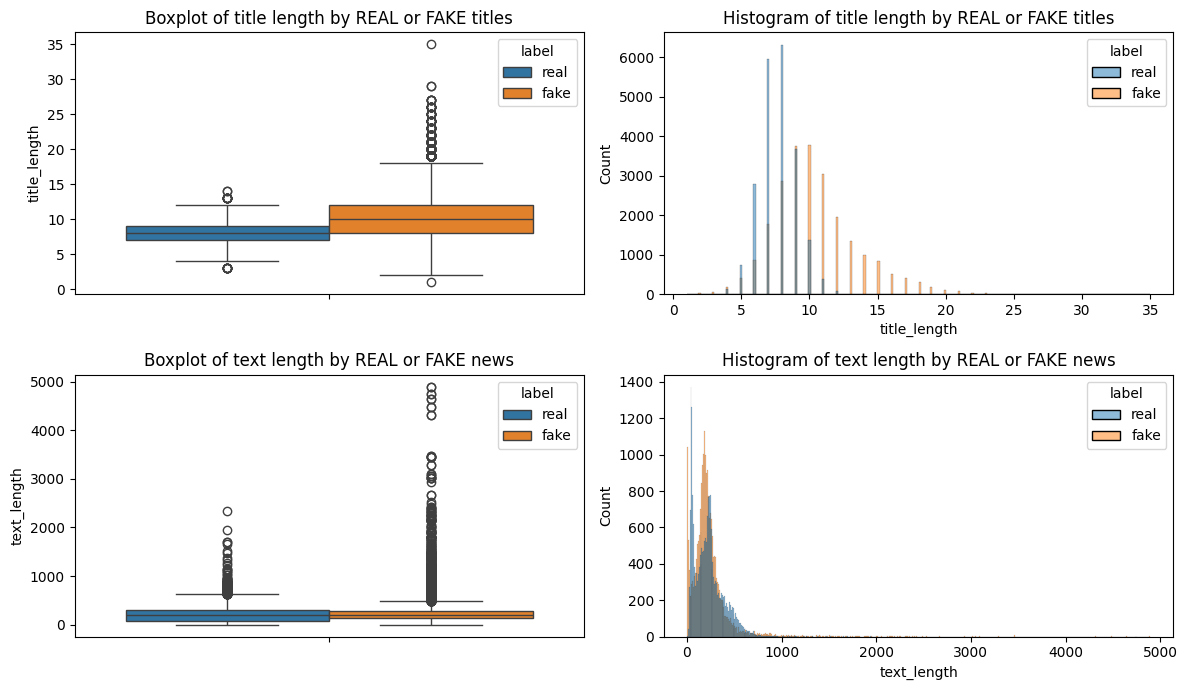

In [45]:
df_eda["title_length"] = df_eda["title_clean"].str.len()
df_eda["text_length"] = df_eda["text_clean"].str.len()

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
sns.boxplot(y="title_length", data=df_eda, hue="label", hue_order=["real", "fake"])
plt.title("Boxplot of title length by REAL or FAKE titles")

plt.subplot(2, 2, 3)
sns.boxplot(y="text_length", data=df_eda, hue="label", hue_order=["real", "fake"])
plt.title("Boxplot of text length by REAL or FAKE news")

plt.subplot(2, 2, 2)
sns.histplot(x="title_length", data=df_eda, hue="label", hue_order=["real", "fake"])
plt.title("Histogram of title length by REAL or FAKE titles")

plt.subplot(2, 2, 4)
sns.histplot(x="text_length", data=df_eda, hue="label", hue_order=["real", "fake"])
plt.title("Histogram of text length by REAL or FAKE news")

plt.tight_layout()
plt.show()

🔔  Text lenght insight:

As it's shown in the boxplot of the title lenght distribution, for the fake news we observe a distribution shift toward higher levels and that could be a first clue that alarm us on the veracity of the news.

## Sentiment Analysis

In [49]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [50]:
sia = SentimentIntensityAnalyzer(
    lexicon_file="data/sentiment/vader_lexicon/vader_lexicon.txt"
)


def get_sentiment_score(text):
    polarity_score = sia.polarity_scores(text)["compound"]
    if polarity_score <= -0.6:
        return "Strongly Negative"
    elif polarity_score <= -0.2:
        return "Negative"
    elif polarity_score <= 0.2:
        return "Neutral"
    elif polarity_score <= 0.6:
        return "Positive"
    else:
        return "Strongly Positive"


df_eda["title_sentiment"] = df_eda["title"].apply(get_sentiment_score)
df_eda["text_sentiment"] = df_eda["text"].apply(get_sentiment_score)

df_eda.head()

,index,title,text,subject,date,label,label_enc,title_clean,text_clean,title_length,text_length,title_sentiment,text_sentiment
0,0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON - The head of a conservative Repub...,politicsNews,"December 31, 2017",real,0,"[budget, fight, loom, republican, flip, fiscal...","[washington, head, conservative, republican, f...",7,435,Negative,Strongly Positive
1,1,U.S. military to accept transgender recruits o...,WASHINGTON - Transgender people will be allow...,politicsNews,"December 29, 2017",real,0,"[military, accept, transgender, recruit, monda...","[washington, transgender, people, allowed, fir...",6,374,Positive,Neutral
2,2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON - The special counsel investigatio...,politicsNews,"December 31, 2017",real,0,"[senior, republican, senator, let, mueller, job]","[washington, special, counsel, investigation, ...",6,256,Neutral,Strongly Negative
3,3,FBI Russia probe helped by Australian diplomat...,WASHINGTON - Trump campaign adviser George Pa...,politicsNews,"December 30, 2017",real,0,"[fbi, russia, probe, helped, australian, diplo...","[washington, trump, campaign, adviser, george,...",8,225,Neutral,Negative
4,4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON - President Donald Trump c...,politicsNews,"December 29, 2017",real,0,"[trump, want, postal, service, charge, much, a...","[seattle, washington, president, donald, trump...",8,486,Positive,Positive


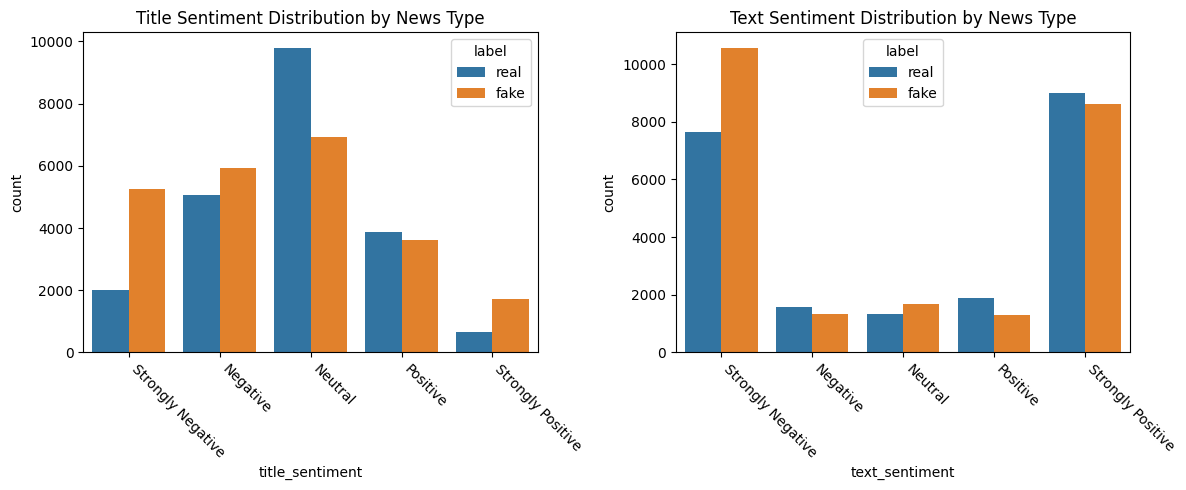

In [52]:
order = ["Strongly Negative", "Negative", "Neutral", "Positive", "Strongly Positive"]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x="title_sentiment", order=order, data=df_eda, hue="label")
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=-45, ha="left")
plt.title("Title Sentiment Distribution by News Type")
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x="text_sentiment", order=order, data=df_eda, hue="label")
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=-45, ha="left")
plt.title("Text Sentiment Distribution by News Type")

plt.tight_layout()
plt.show()

🔔  Sentiment analysis insight:

From the histogram we can assert that especially in the title (but also in the text) if the content is extreme (positive or negative) is more likely that it's a fake news

## Topic Model

In [ ]:
df_eda.isna().sum()

In [ ]:
df_eda['full_text'] = df_eda['title'] + ' ' + df_eda['text']

In [ ]:
df_eda['tokens'] = df_eda['full_text'].apply(preprocess)

### LDA

In [ ]:
df_lda = df_eda.copy()

POS tagging used to clean the dictionary

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["ner"])
texts = df_lda['full_text'].tolist()  

# POS tagging
pos_allowed = {"NOUN", "PROPN", "ADJ"}
filtered_tokens = []
for doc in tqdm(nlp.pipe(texts, batch_size=128, n_process=-1), total=len(texts)):
    tokens = [
        tok.lemma_.lower()
        for tok in doc
        if tok.pos_ in pos_allowed and not tok.is_stop and tok.is_alpha
    ]
    filtered_tokens.append(tokens)

# Dictionary
dictionary = corpora.Dictionary(filtered_tokens)
dictionary.filter_extremes(no_below=10, no_above=0.5)

# BoW
corpus = [dictionary.doc2bow(text) for text in filtered_tokens]

# LDA
lda_model = models.LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    passes=10,
    random_state=42
)

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

🔔 Topic description:

Looking at the key words by topic returned from the LDA model we can try to make an interpretation of the clusters:

- *Topic 0*: **Migration and international governance**
    - Keyword: year, government, country, refugee, muslim, united, people, state
    - References to refugees, states, populations, and government institutions

- *Topic 1*: **Geopolitics and international conflicts**
    - Keyword: syria, military, russia, united, war, iran, states, official
    - Focus on Syria, Russia, Iran and military operations

- *Topic 2*: **US election campaign and presidential politics**
    - Keyword: clinton, obama, donald, hillary, campaign, republican, video, white
    - Many references to political figures and political communication

- *Topic 3*: **Education, legislation and homeland security**
    - Keyword: student, law, school, bill, house, police, republican
    - A mix of school, law and law enforcement topics

- *Topic 4*: **Media, news and political scandals**

    - Keyword: news, medium, story, clinton, fbi, email, hillary, police
    - Topics related to media, news narrative and scandals

In [ ]:
dominant_info = [max(doc, key=lambda x: x[1]) for doc in doc_lda]
df_lda["topic"] = [topic for topic, prob in dominant_info]
df_lda["topic_prob"] = [prob for topic, prob in dominant_info]

In [ ]:
plot_df = df_lda.groupby(['topic', 'label']).size().unstack(fill_value=0)
plot_df['total'] = plot_df.sum(axis=1)
plot_df['fake_pct'] = plot_df['fake'] / plot_df['total'] * 100

# set the plot
ax = df_lda.groupby(['topic', 'label']).size().unstack().plot(
    kind='barh', stacked=True, figsize=(8,6)
)
# add percentage
for i, (total, pct) in enumerate(zip(plot_df['total'], plot_df['fake_pct'])):
    ax.text(total + 1, i, f'{pct:.1f}%', va='center', fontsize=10)
# add legend text
handles, labels = ax.get_legend_handles_labels()
extra_label = Patch(color='none', label='% fake/total')
handles.append(extra_label)
labels.append('% fake/total')
ax.legend(handles, labels, loc='best')

plt.xlabel("N° articles")
plt.ylabel("Topic")
plt.title("Distribution fake-real by topic")
plt.tight_layout()
plt.show()


🔔 Topic fake-real proportion:

As clearly the barchart shows the topic 2 (US election campaign and presidential politics) is the one with the most fake news either in absolute frequency either in percentage. Also the topic 4 (Media, news and political scandals) has an high fake news ratio.

This is already a clue about how some topics are more prone to fake news.

In the following analysis is performed the NER model just on the 10% of the df due to computational cost. 

It's gonna be extract the most significant articles for every topic (800) and then perform the NER to analyze some pattern about the entities.

In [ ]:
# NER
N = 800  # 5 topic x 800 = 4000 articles

top_docs_per_topic = []

for topic_id in range(lda_model.num_topics):
    top_docs = df_lda[df_lda["topic"] == topic_id].sort_values(
        by="topic_prob", ascending=False
    ).head(N)
    top_docs_per_topic.append(top_docs)

df_top_for_ner = pd.concat(top_docs_per_topic).reset_index(drop=True)
df_top_for_ner = df_top_for_ner.drop_duplicates(subset=["full_text"])

nlp = spacy.load("en_core_web_sm")

entities_data = []

for idx, row in df_top_for_ner.iterrows():
    doc = nlp(row["full_text"])
    for ent in doc.ents:
        entities_data.append({
            "doc_id": idx,
            "topic": row["topic"],
            "entity_text": ent.text,
            "entity_label": ent.label_
        })

df_entities = pd.DataFrame(entities_data)


In [ ]:
# counting
count_ent = pd.DataFrame(df_entities.groupby("topic")["entity_text"].value_counts().groupby(level=0).head(10), columns=['count'])
count_type_ent = pd.DataFrame(df_entities.groupby("topic")["entity_label"].value_counts().unstack(fill_value=0))

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15,10))
axes = axes.flatten()

for i in count_ent.index.get_level_values(0).unique():
# Seleziona solo le righe con topic == 0
    df_sub = count_ent.loc[i]  # questo restituisce un DataFrame indicizzato da 'entity_text'

    # Se 'entity_text' è ancora nell'indice, resetta se vuoi come colonna
    df_sub = df_sub.reset_index()  # ora 'entity_text' è una colonna

    # Plot
    axes[i].bar(df_sub['entity_text'], df_sub['count'])
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('Entity Text')
    axes[i].set_ylabel('Count')
    axes[i].set_title(f"Entity count for topic {i}")
    
plt.tight_layout()
plt.show()

We can see as some entities are much more contained in the fake news text ad *Trump*, *Clinton*, *Senate*.

Selected some of the most important entities the following visualization is going to help to understand on the whole dataset of news which words (entities) are more frequent in fake news.

In [ ]:
key_fake_words = ['Trump', 'Republican', 'Republicans', 'Obama', 'US', 'U.S.', 'Hillary Clinton', 'Clinton']
for target in key_fake_words:
    plot_distribution_entity(df_lda, target, search_col='full_text')

🔔 Allert-words insight:

Set of word analyzed:
- *Trump*: has a fake ratio of 60%, but the distribution shows that more the counting of the word in the news increase higher is the fake ratio, indeed from the 40 occurrences per article it's almost 100% fake. This means that when the word Trump is written a lot of times it's an allert for a fake news.
- *Republican* and *Republicans*: those 2 words have around 50% fake ratio and the distributions don't show any trend linked to an higher ratio.
- *Obama*: for this word is the same argument as for the 'Trump' word. The ratio is around 60-70% in the low occurences articles but when the counting increases over 15 the ratio is much more higher, so even this word is an allert for fake news.
- *US* and *U.S.*: the distributions of the 2 words are opposite showing us that if is written with the dots is much more reliable (fake ratio: 19% with dots vs 80% without). The distribution of 'US' shows that if it'swritten more than 2 times in the article the probability of a fake news is from 90 to 100%. According to this analysis the 0 bar of *U.S.* word (no presence in the text) shows high fake ratio (70%).
- *Hillary Clinton* and *Clinton*: both the words are very fake-prone (67%-75% fake ratio), the distribution shows that for the all name already when it's written 3 times or more the ratio rise to 90% and more while for just 'Clinton', those ratios are reached with a minimum occurrences number of 30.


In the end this analysis showed that there are some kind of news (topic like US election campaign, presidential politics, media, news and political scandals) much more fake-prone and in these ones there are pattern and allert words such as *Trump*, *US* (without dots), *Obama*, *Hillary Clinton* and *Clinton*. These words are more reliable indicators of fake news when the occurrences in the article are high.

3. Do fake news headlines exhibit recurring patterns?

To answer this question we can use the NER method as done for the full text

In [ ]:
nlp = spacy.load("en_core_web_sm")

entities_data = []

for idx, row in df_lda.iterrows():
    doc = nlp(row["title"])
    for ent in doc.ents:
        entities_data.append({
            "doc_id": idx,
            "topic": row["topic"],
            "entity_text": ent.text,
            "entity_label": ent.label_
        })

df_title_ent = pd.DataFrame(entities_data)

In [ ]:
# counting
count_title_ent = pd.DataFrame(df_title_ent.groupby("topic")["entity_text"].value_counts().groupby(level=0).head(10),
                               columns=['count'])
count_type_title_ent = pd.DataFrame(df_title_ent.groupby("topic")["entity_label"].value_counts().unstack(fill_value=0))

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15,10))
axes = axes.flatten()

for i in count_title_ent.index.get_level_values(0).unique():
    df_sub = count_title_ent.loc[i] 
    df_sub = df_sub.reset_index()  
    
    axes[i].bar(df_sub['entity_text'], df_sub['count'])
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('Entity Text')
    axes[i].set_ylabel('Count')
    axes[i].set_title(f"Entity count for topic {i}")
    
plt.tight_layout()
plt.show()

In [ ]:
key_fake_words = ['Trump', 'GOP', 'Republican', 'Republicans', 'Russia','Russian',
                  'Obama','U.S.', 'Clinton', 'HILLARY', 'Hillary', 'FBI', 'CIA', 'CNN']
for target in key_fake_words:
    plot_distribution_entity(df_lda, target, search_col='title', division=False)

🔔 Title insight:

For the most frequent entities recognized by topic a lot of them have an higher rate of real ratio then fake ratio as *U.S.*, *Russian*, *Russia*, *Republican* meaning that those are not signals of a fake news, while words like *Clinton*, *Republicans* have a 55-45 balance fake-real not so much reliable on identify fake news.

On the other hand we can recognize the same behavior in the other words analyzed because when those words aren't in the title the chance that it's a fake news is around 50% (random), but when they are in the fake ratio increase a lot sometimes almost 100%:
*Trump* (60%), *GOP* (99%), *Obama* (68%), *HILLARY* (100%), *Hillary* (97%), *FBI* (70%), *CIA* (83%) *CNN* (90%).

These are pattern useful to recognize the fake news from the title and all these terms are in the sphere of the presidential, election, media, scandals topic. 

# Classification Model

Testing models:

con TF-IDF
- LR
- RF
- MultinomialNB
- XGBoost
- LightGBM
- Neural Network -> MLP

## Preparing data

### Cleaning from *Reuters* tag

In the REAL news there is always (or almost) the tag *Reuters*, so we need to clean it to avoid overfitting from the classification models.

In [77]:
# check string Reuters if is in all the real news
print(f"Number of real news: {len(true_news)}")
word = "(Reuters)"
count_word = 0 
real_count = 0
fake_count = 0
for i in range(0,len(df)):
    if word in df.loc[i]['text'].split():
        count_word+=1
        if df.loc[i]['label']=='real':
            real_count+=1
        if df.loc[i]['label']=='fake':
            fake_count+=1
print(f"Number of news that contain the word \'{word}\' in the text col: {count_word}")
print(f"{real_count} on the {count_word} news with \'{word}\' are real, {(real_count/count_word)*100:.2f} %")
print(f"{fake_count} on the {count_word} news with \'{word}\' are fake, {(fake_count/count_word)*100:.2f} %")

Number of real news: 21417
Number of news that contain the word '(Reuters)' in the text col: 21245
21237 on the 21245 news with '(Reuters)' are real, 99.96 %
8 on the 21245 news with '(Reuters)' are fake, 0.04 %


In [78]:
df['text'] = df['text'].str.replace(word, '', regex=False)

### Encoding target feature

In [79]:
label_enc = {'real':0, 'fake':1}
df['label_enc'] = df['label'].map(label_enc)

### Hold out

In [80]:
X = df['text']
y = df['label_enc']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

### Preprocessing

In [82]:
scaler = MaxAbsScaler()

In [83]:
tfidf = TfidfVectorizer(max_df=0.95,          
                        min_df=2,
                        ngram_range=(1,2)
                        )

In [84]:
# creating the list for models
List_Classification_Models =[]
List_Classification_Models.append(('LR', LogisticRegression(C=1.0, penalty="l2", random_state=random_seed), 
                                   scaler))

List_Classification_Models.append(('Multinomial_NB', MultinomialNB(alpha=1.0),
                                   'passthrough'))

List_Classification_Models.append(('RF', RandomForestClassifier(n_estimators=100, 
                                                                max_depth=10,
                                                                max_features='sqrt',
                                                                n_jobs=-1,
                                                                random_state=random_seed),
                                   'passthrough'))
List_Classification_Models.append(('XGB', xgb.XGBClassifier(n_estimators=100,        
                                                            learning_rate=0.1,       
                                                            max_depth=6,           
                                                            subsample=0.8,          
                                                            colsample_bytree=0.8,
                                                            use_label_encoder=False,
                                                            eval_metric='logloss',
                                                            objective='binary:logistic',
                                                            random_state=random_seed),
                                   'passthrough'))
List_Classification_Models.append(('LightGBM', LGBMClassifier(objective='binary',
                                                            n_estimators=300,
                                                            learning_rate=0.1,
                                                            num_leaves=31,           
                                                            subsample=0.8,
                                                            colsample_bytree=0.8,
                                                            max_depth=7,
                                                            verbosity=-1,
                                                            random_state=random_seed),
                                   'passthrough'))
List_Classification_Models.append(('MLP', MLPClassifier(hidden_layer_sizes=(100,),
                                                        activation='relu',           
                                                        solver='adam',             
                                                        max_iter=100,                
                                                        early_stopping=True, 
                                                        n_iter_no_change=5,
                                                        validation_fraction=0.05,
                                                        tol=1e-3,        
                                                        random_state=random_seed),
                                   scaler))

## Models with just articles text

In [ ]:
results = []

for name, model, scaler in List_Classification_Models:

    pipe = make_pipeline(name, model, scaler, 
                         vectorizer=tfidf, 
                         preprocessor =  TextPreprocessor(output='string'),
                         random_seed=random_seed)
    
    start_time = time.time()

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    
    result = get_performance_metrics(y_test, y_pred, y_proba, name)
    results.append(result)
    
    print(f"Finish training {name} Time: {int(minutes)} min {seconds:.2f} sec")

    
# converti in DataFrame i risultati
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

In [ ]:
results_df

## Models with title and text 

In [26]:
X_2 = df[['title', 'text']]
y_2 = df['label_enc']
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, stratify=y)

In [ ]:
# needed to manage the different columns of title and text
column_transformer = ColumnTransformer(transformers=[
    ('title_tfidf', Pipeline([
        ('prep', TextPreprocessor(output='string')),
        ('tfidf', TfidfVectorizer())
    ]), 'title'),
    
    ('text_tfidf', Pipeline([
        ('prep', TextPreprocessor(output='string')),
        ('tfidf', TfidfVectorizer())
    ]), 'text'),
])

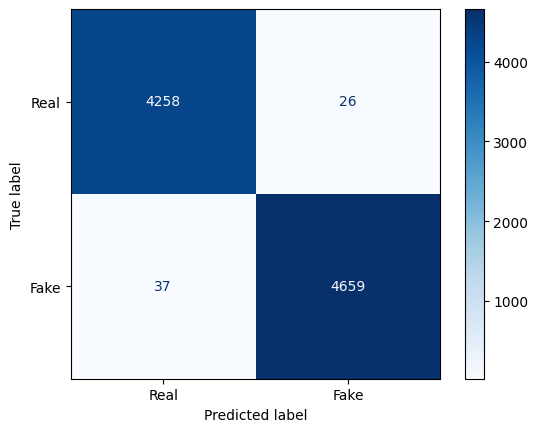

Finish training LR Time: 3 min 42.46 sec


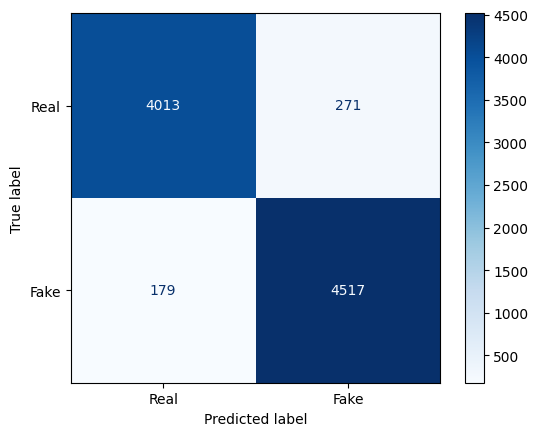

Finish training Multinomial_NB Time: 1 min 58.24 sec


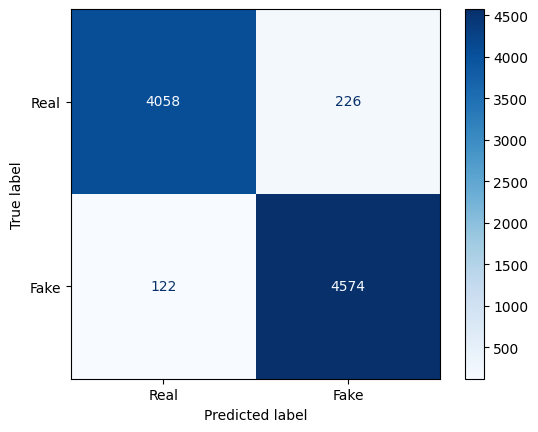

Finish training RF Time: 1 min 53.28 sec


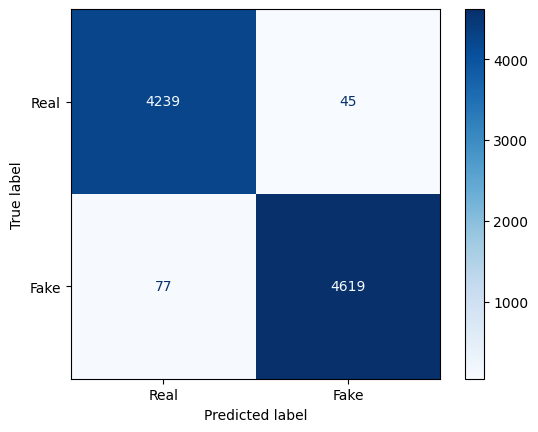

Finish training XGB Time: 2 min 58.36 sec


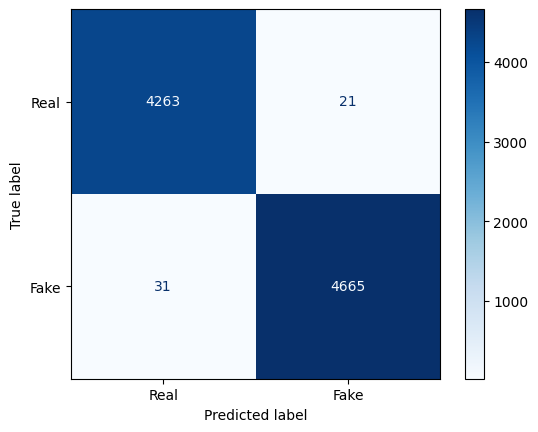

Finish training LightGBM Time: 2 min 35.06 sec


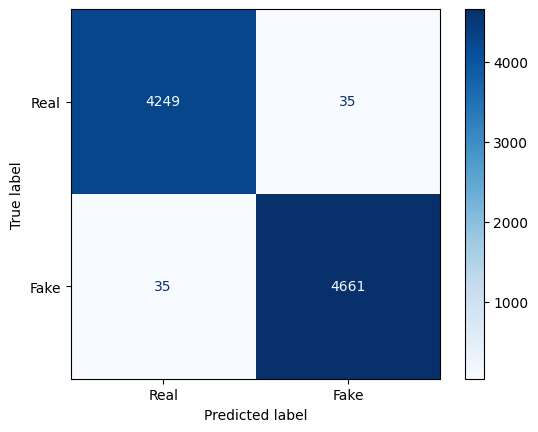

Finish training MLP Time: 15 min 12.26 sec


In [ ]:
results = []

for name, model, scaler in List_Classification_Models:

    pipe = make_pipeline(name, model, scaler, 
                         vectorizer='passthrough',      # because the vectorization is already performed 
                                                        # in the preprocess for every col
                         preprocessor = column_transformer,
                         random_seed=random_seed)
    
    start_time = time.time()

    pipe.fit(X_2_train, y_2_train)
    y_pred = pipe.predict(X_2_test)
    y_proba = pipe.predict_proba(X_2_test)[:,1]
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    
    result = get_performance_metrics(y_2_test, y_pred, y_proba, name, conf=True)
    results.append(result)
    
    print(f"Finish training {name} Time: {int(minutes)} min {seconds:.2f} sec")

    
# convert the results in a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

In [23]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
4,LightGBM,0.994209,0.995519,0.993399,0.994457,0.999808
0,LR,0.992984,0.994450,0.992121,0.993284,0.999561
5,MLP,0.992205,0.992547,0.992547,0.992547,0.999340
3,XGB,0.986414,0.990352,0.983603,0.986966,0.998818
2,RF,0.961247,0.952917,0.974020,0.963353,0.992144
1,Multinomial_NB,0.949889,0.943400,0.961882,0.952552,0.989584


🔔 Models testing insight:


To evaluate the goodness of the models performance we need to check if there is overfitting (possible given such high performance) and one way to do it is to perform the cross validation. 

Since the cross validation is computationally very expensive it's performed only on the best 3 models so LightGBM, Logistic Regression and MLP.

## Cross Validation

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}
reports_cv = []
for mod in ['MLP', 'LightGBM', 'LR']:
    name, model, scaler = extract_params(List_Classification_Models, mod)
    pipe = make_pipeline(name, model, scaler, 
                         vectorizer='passthrough', 
                         preprocessor=column_transformer, 
                         random_seed=random_seed)
    start_time = time.time()

    reports_cv.append(evaluate_model(name=name, 
                                        pipeline = pipe, 
                                        X=X_2, y=y_2,
                                        cv=cv,
                                        scoring=scoring))

    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    
    print(f"Finish training {name} (cv) Time: {int(minutes)} min {seconds:.2f} sec")
    
report_cv_df = pd.DataFrame(reports_cv)

Finish training MLP (cv) Time: 122 min 23.07 sec
Finish training LightGBM (cv) Time: 6 min 20.62 sec
Finish training LR (cv) Time: 3 min 44.45 sec


In [30]:
report_cv_df

,Model,Accuracy Mean,Accuracy Std,F1 Mean,F1 Std,ROC AUC Mean,ROC AUC Std,Fit Time Mean (s),Fit Time Std (s),Score Time Mean (s),Score Time Std (s)
0,MLP,0.991046,0.000861,0.991442,0.000829,0.999461,0.000143,4646.621222,1658.745105,120.750430,44.964998
1,LightGBM,0.993808,0.001269,0.994079,0.001215,0.999776,0.000054,278.044450,16.556033,75.872822,8.039162
2,LR,0.991336,0.000702,0.991714,0.000673,0.999338,0.000197,149.884930,0.504748,72.872455,0.853210


🔔 Cross Validation insight:

Even with cross vaildation the model **LightGBM** has the best performance and isn't susceptible to overfitting because the metrics are praticaly the same.

## Grid Search

In [ ]:
# Parameters
param_grid = {'lgbm__max_depth': [-1, 10, 20]}

name, model, scaler = extract_params(List_Classification_Models, 'LightGBM')
name = 'lgbm'
pipe = make_pipeline(name, model, scaler, 
                         vectorizer='passthrough', 
                         preprocessor=column_transformer, 
                         random_seed=random_seed)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'f1': make_scorer(f1_score),
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc'
}

# Grid Search
grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_2, y_2)  

print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params: {'lgbm__n_estimators': 300}
Best score: 0.9940089732277215


# Export Pipeline

In [ ]:
column_transformer = ColumnTransformer(transformers=[
    ('title_tfidf', Pipeline([
        ('prep', TextPreprocessor(output='string')),
        ('tfidf', TfidfVectorizer())
    ]), 'title'),
    
    ('text_tfidf', Pipeline([
        ('prep', TextPreprocessor(output='string')),
        ('tfidf', TfidfVectorizer())
    ]), 'text'),
])
name = 'LightGBM'
model = LGBMClassifier(objective='binary',
                        n_estimators=300,
                        learning_rate=0.1,
                        num_leaves=31,           
                        subsample=0.8,
                        colsample_bytree=0.8,
                        max_depth=20,
                        verbosity=-1,
                        random_state=0)
final_pipeline = Pipeline([
        ('preprocessing', column_transformer),  
        (name, model)
])

final_pipeline.fit(X_2, y_2)

joblib.dump(final_pipeline, 'fake_news_detector.pkl')


['fake_news_detector.pkl']

In [ ]:
custom_code = '''
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.utils import simple_preprocess


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, output='string'):
        """
        output: 'string' → return a string (for TF-IDF)
                'tokens' → return a list of tokens (for Word2Vec)
        """
        self.output = output

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        
        def preprocess(text):
            tokens = simple_preprocess(text, deacc=True, min_len=3)
            tokens = [t for t in tokens if t not in stop_words]
            tokens = [lemmatizer.lemmatize(t) for t in tokens]
            if self.output == 'string':
                return ' '.join(tokens)
            elif self.output == 'tokens':
                return tokens
            else:
                raise ValueError("output must be 'string' or 'tokens'")

        return X.apply(preprocess)
'''

with open("custom_transformer.py", "w") as f:
    f.write(custom_code)

## Try the model

In [ ]:
num = random.randint(0, 44898)
test = df.loc[num]
col= ['title', 'text']
y_test = test['label']
test = pd.DataFrame(test[col]).transpose()
display(test)
y_pred = final_pipeline.predict(test)
print(f"Model prediction = {y_pred}, News tag = {y_test}")

,title,text
42337,"OBAMA GIVES ILLEGAL ALIENS IN FLINT, MI Amnest...",Because people who scale border walls and brea...


Model prediction = [1], News tag = fake


# Conclusions

In the analysis above we saw that some information as: lenght of the title, presence of some particular words (or better entities) or the sentiment expressed are signal that can guide us in the detenction of a fake news.

After the analysis of models including just the *text* feature and with *text* and *title* features, the second group reached better perfomance even if only slightly.

Talking about the final predictive model the choice went on the **LightGBM** that showed the best performance even with cross validation with an *accuracy* of 99.38% and a *f1 score* of 99.40%.

To avoid the the chance of overfitting and have always a reliable tool the model needs to be update when new data are available.

To improve the model a further work could consider:
- more feature as date, subject of the news (given by a topic model in a homogeneous way for real and fake news)
- other predictive models as SVM (very computational expensive)
- perform a grid search not only on the best model but even on others that have similar performance metrics
- perform a grid search on more parameters to consider a greater number of scenarios 
- use of vectorization with the model word2vec (to train on our data or using a pre trained model) joined with a MLP classifier

All these options require much more time to be tested and more than that require many computational resources.

The model delivered in the file **fake_news_detector.pkl** reached the compromise of being accurate and lean in the same time.

N.B. : Having created custum object as the *TextPreprocessor* it's necessary that the ML engineer and Web Development team make sure that all the dependencies are satisfied, to avoid errors on loading the model. For this scope it would be a good practice create a .py file where are defined all the custum objects (like *custom_trasformer.py*).